# **Similitud entre productos**

In [8]:
#!pip install langdetect
#!pip install googletrans==4.0.0-rc1
#pip install wordcloud
#pip install gensim
#pip install pyemd
#pip install textblob
#pip install POT
#pip install gputil

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect, DetectorFactory, LangDetectException
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import euclidean_distances
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from pyemd import emd
import numpy as np
import math
#from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from textblob import TextBlob
from scipy.spatial.distance import cdist
import torch
from sklearn.cluster import KMeans as skKMeans
import psutil
import GPUtil
import time
import os
import gc
import sys

In [2]:
import cupy as cp
import cudf
import cuml
from cuml.feature_extraction.text import TfidfVectorizer as cuTfidfVectorizer
from cuml.metrics import pairwise_distances
from cuml.manifold import TSNE
from cuml.cluster import KMeans as cuKMeans

/home/insightlab/anaconda3/envs/similarity/lib/python3.10/site-packages/cupy/_environment.py:540: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
/home/insightlab/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not fou

In [3]:
import nltk

# Descargar el conjunto de stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/insightlab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Asegurar resultados consistentes en la detección de idiomas
DetectorFactory.seed = 0

In [5]:
# Configurar el dispositivo para usar CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Cargar y Preprocesar los Datos

In [6]:
df= pd.read_csv('/home/insightlab/Documents/MercadoLibre/arquivos/items_titles_test.csv', encoding='latin1')
df

,ITE_ITEM_TITLE
0,TÃªnis Olympikus Esporte Valente - Masculino Kids
1,Bicicleta Barra Forte Samy C/ 6 Marchas Cubo C...
2,TÃªnis Usthemp Slip-on TemÃ¡Âtico - Labrador 2
3,TÃªnis Casual Feminino Moleca Tecido Tie Dye
4,TÃªnis Star Baby Sapatinho Conforto + Brinde
...,...
9995,Chuteira Futsal Oxn Velox 3 Infantil
9996,Sapatenis Casual Masculino Estiloso 24horas Co...
9997,TÃªnis Feminino Infantil Molekinha Tie Dye
9998,TÃªnis Feminino Leve Barato Ganhe 1 Colchonete...


In [7]:
# Número de títulos únicos
num_unique_titles = df['ITE_ITEM_TITLE'].nunique()
print(f"\nNúmero de títulos únicos: {num_unique_titles}")


Número de títulos únicos: 10000


Limpieza de datos

In [8]:
# Convertir a minúsculas
df['ITE_ITEM_TITLE'] = df['ITE_ITEM_TITLE'].str.lower()

In [9]:
# Eliminar valores nulos
df = df.dropna(subset=['ITE_ITEM_TITLE'])

Eliminación de caracteres especiales

In [6]:
# Definir una función para limpiar el texto
def clean_text(text):
    # Remover caracteres especiales y dígitos
    text = re.sub(r'[^a-zA-Zãõáéíóúâêôç\s]', '', text)
    return text

In [11]:
# Aplicar la función de limpieza
df['ITE_ITEM_TITLE'] = df['ITE_ITEM_TITLE'].apply(clean_text)

Eliminación de stopwords:
*   Quitar palabras comunes como "de", "a", "o", "que", "e", etc., que no aportan mucho valor al significado del texto.

In [12]:
portuguese_stopwords = set(stopwords.words('portuguese'))

In [7]:
def remove_stopwords_pt(text):
    words = text.split()
    filtered_words = [word for word in words if word not in portuguese_stopwords]
    return ' '.join(filtered_words)

In [14]:
# Aplicar la función para remover stopwords
df['ITE_ITEM_TITLE'] = df['ITE_ITEM_TITLE'].apply(remove_stopwords_pt)

In [15]:
df

,ITE_ITEM_TITLE
0,tãnis olympikus esporte valente masculino kids
1,bicicleta barra forte samy c marchas cubo c ro...
2,tãnis usthemp slipon temãâtico labrador
3,tãnis casual feminino moleca tecido tie dye
4,tãnis star baby sapatinho conforto brinde
...,...
9995,chuteira futsal oxn velox infantil
9996,sapatenis casual masculino estiloso horas conf...
9997,tãnis feminino infantil molekinha tie dye
9998,tãnis feminino leve barato ganhe colchonete p ...


In [16]:
# Asignar un ID único a cada título
df['ID'] = range(len(df))

Eliminación de Ruido Contextual y Tokenización

In [8]:
def clean_and_tokenize(title):
    stop_words = set(stopwords.words('portuguese'))
    stemmer = SnowballStemmer('portuguese')
    title = re.sub(r'[^a-zA-Z0-9\s]', '', title)
    tokens = title.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens

In [18]:
df['tokens'] = df['ITE_ITEM_TITLE'].apply(clean_and_tokenize)

In [19]:
df

,ITE_ITEM_TITLE,ID,tokens
0,tãnis olympikus esporte valente masculino kids,0,"[tnis, olympikus, esport, valent, masculin, kids]"
1,bicicleta barra forte samy c marchas cubo c ro...,1,"[biciclet, barr, fort, samy, c, march, cub, c,..."
2,tãnis usthemp slipon temãâtico labrador,2,"[tnis, usthemp, slipon, temtic, labrador]"
3,tãnis casual feminino moleca tecido tie dye,3,"[tnis, casual, feminin, molec, tec, tie, dye]"
4,tãnis star baby sapatinho conforto brinde,4,"[tnis, star, baby, sapatinh, confort, brind]"
...,...,...,...
9995,chuteira futsal oxn velox infantil,9995,"[chuteir, futsal, oxn, velox, infantil]"
9996,sapatenis casual masculino estiloso horas conf...,9996,"[sapaten, casual, masculin, estil, hor, confor..."
9997,tãnis feminino infantil molekinha tie dye,9997,"[tnis, feminin, infantil, molekinh, tie, dye]"
9998,tãnis feminino leve barato ganhe colchonete p ...,9998,"[tnis, feminin, lev, barat, ganh, colchonet, p..."


In [20]:
# Convertir DataFrame de pandas a cudf DataFrame
df_cudf = cudf.DataFrame.from_pandas(df)

coincidencia directa de palabras importantes:

In [21]:
# N-Gramas y TF-IDF
tfidf_vectorizer = cuTfidfVectorizer(ngram_range=(1, 3), min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_cudf['ITE_ITEM_TITLE'])

Vamos a usar Word2Vec ya que nos permite capturar el contexto semántico de las palabras:

In [22]:
# Entrenamiento de Word2Vec Desde Cero
word2vec_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.save("word2vec.model")

Tambien Doc2Vec que nos permite realizar la captura de contexto similar a Word2Vec solo que en lugar de generar embeddings para palabras, genera embeddings para documentos completos, en nuestro caso los títulos completos:

In [23]:
# Entrenamiento de Doc2Vec desde cero
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['tokens'])]
doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=1, workers=4)
doc2vec_model.save("doc2vec.model")

Representación de los títulos

In [9]:
def get_title_vector(title_tokens, model, vector_size=100):
    word_vectors = [model.wv[word] for word in title_tokens if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(vector_size)

In [25]:
df['word2vec_vector'] = df['tokens'].apply(lambda x: get_title_vector(x, word2vec_model))
df['doc2vec_vector'] = [doc2vec_model.dv[i] for i in range(len(df))]

In [10]:
# Cálculo de la Similitud utilizando diferentes técnicas
def wmd_similarity(model, doc1, doc2):
    return model.wv.wmdistance(doc1, doc2)


In [27]:
# Calcular la similitud del coseno utilizando cuML para matrices densas
cosine_sim_tfidf = pairwise_distances(tfidf_matrix.toarray(), metric='cosine', device=device)

In [28]:
# Para Word2Vec y Doc2Vec, - CPU
cosine_sim_word2vec = cosine_similarity(np.stack(df['word2vec_vector'].values))
cosine_sim_doc2vec = cosine_similarity(np.stack(df['doc2vec_vector'].values))

Usaremos Word Mover’s Distance (WMD) que nos permite medir la distancia mínima que "deberían viajar" los embeddings de las palabras en un título para coincidir con las palabras en otro título, utilizando Word2Vec. WMD es extremadamente poderoso para capturar similitudes semánticas profundas entre textos. Mide cómo las palabras se pueden alinear entre dos textos de manera óptima. Puede capturar relaciones de significado más complejas que el coseno tradicional porque se enfoca en la "distancia" entre el significado de las palabras.

Este proceso es que usualmente demora bastante tiempo ya que requiere bastante recurso computacional

In [28]:
# Calcular WMD en CPU
wmd_sim = np.array([[wmd_similarity(word2vec_model, doc1, doc2) for doc2 in df['tokens']] for doc1 in df['tokens']])

2024-09-03 10:42:01.827039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 10:42:01.904278: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-03 10:42:01.927433: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-03 10:42:02.102429: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-03 10:42:03.010310: W tensorflow/compiler/tf2

In [29]:
# Normalización de WMD (invertir y normalizar)
wmd_sim = 1 / (1 + wmd_sim)
wmd_sim = (wmd_sim - np.min(wmd_sim)) / (np.max(wmd_sim) - np.min(wmd_sim))

Estamos usando estos diferentes metodos para poder reducir sesgos de depender demasiado de un solo enfoque, o los introducidos por una técnica particular, ademas cada técnica captura diferentes aspectos de la similitud entre los títulos.

Aplicamos un promedio entre los cuatro métodos para darle el mismo peso a cada técnica en el cálculo  y tener un score más balanceado de las métricas:

In [32]:
# Convertir todos los arrays a cupy para que puedan ser sumados
cosine_sim_tfidf = cp.array(cosine_sim_tfidf)
cosine_sim_word2vec = cp.array(cosine_sim_word2vec)
cosine_sim_doc2vec = cp.array(cosine_sim_doc2vec)
wmd_sim = cp.array(wmd_sim)

# Ahora puedes sumar los arrays y hacer el ensemble
ensemble_score = (cosine_sim_tfidf + cosine_sim_word2vec + cosine_sim_doc2vec + wmd_sim) / 4

## Técnicas de clustering

Vamos a integrar el clustering en el cálculo del score para mejorar la relevancia de las similitudes detectadas, haciendo que el análisis tenga en cuenta no solo la similitud textual sino también la agrupación semántica de los títulos. Esto proporciona un enfoque más robusto para identificar productos similares.

Antes de aplicar una técnica de clustering, se analizaron los datos y se decidió optar por K-Means. Aunque inicialmente se consideró GaussianMixture por su capacidad para aplicar clustering basado en modelos de mezcla gaussiana, que permite que cada cluster tenga su propia forma y tamaño, ofreciendo mayor flexibilidad en comparación con K-Means, que asume que los clusters son esféricos y de tamaño similar, se optó finalmente por K-Means debido a su simplicidad y eficiencia computacional. En el caso de grandes volúmenes de datos, K-Means es más escalable y rápido, lo que lo hace adecuado para este problema. También se evaluó el uso de DBSCAN, que agrupa puntos densamente conectados, pero se descartó debido a sus limitaciones en términos de escalabilidad para grandes datasets.

**Índice de Davies-Bouldin (DBI)**

Una de las caracteristicas que tiene K-Means es que se debe definir su número de clusters a trabajar, sin embargo para encontrar el valor más óptimo de número de clustering la metrica DBI nos permitirá evaluar su calidad, es decir, mientras un Index DB más bajo indica clusters más compactos y separados, lo que sugiere un mejor agrupamiento.

In [15]:
def optimize_n_clusters(title_vectors_cudf, title_vectors_numpy, n_clusters_range):
    best_db_index = float('inf')
    best_n_clusters = None
    best_labels = None

    for n_clusters in range(n_clusters_range[0], n_clusters_range[1] + 1):
        clustering = cuKMeans(n_clusters=n_clusters, random_state=0, n_init=10) #Controlamos la aleatoriedad en la inicialización y  cuántas veces se ejecuta el algoritmo con diferentes inicializaciones
        labels = clustering.fit_predict(title_vectors_cudf)
        
        # Convertir etiquetas a NumPy para calcular el índice de Davies-Bouldin
        labels_numpy = labels.to_numpy()

        # Calcular el índice de Davies-Bouldin usando sklearn en CPU
        db_index = davies_bouldin_score(title_vectors_numpy, labels_numpy)
        
        if db_index < best_db_index:
            best_db_index = db_index
            best_n_clusters = n_clusters
            best_labels = labels_numpy  # Usar las etiquetas en NumPy
            #print(f"n clusters: {best_n_clusters} con un Index DB: {best_db_index}")
        
        #n_clusters += 10

    return best_n_clusters, best_labels, best_db_index

In [63]:
# Cálculo de la similitud utilizando embeddings
title_vectors_cudf = cudf.DataFrame.from_records(np.stack(df['doc2vec_vector'].values))
title_vectors = np.stack(df['doc2vec_vector'].values)

Como valor maximo de clustering vamos a tomar el valor entero más cercano a su total dividido entre 10, que en este caso seria mil, ya que nuestro datasets tiene un total de 10mil lineas de titulo

In [64]:
c_max = math.floor(num_unique_titles / 10)
n_clusters_range = (10, c_max )
best_n_clusters, best_labels, best_db_index = optimize_n_clusters(title_vectors_cudf, title_vectors, n_clusters_range)
df['cluster'] = best_labels
print(f"\nEl más óptimo número de cluster aplicados fue: {best_n_clusters} con un Index DB: {best_db_index}")

n clusters: 10 con un Index DB: 1.8657171736441227
n clusters: 11 con un Index DB: 1.8432836239652737

El más óptimo número de cluster aplicados fue: 11 con un Index DB: 1.8432836239652737


Para poder comprender un poco como se esta distribuyendo nuestros datos en el clusters, vamos a plasmarlo en un grafico de dispersion, utilizando técnicas de reducción de dimensionalidad, como t-SNE para proyectar los vectores de alta dimensión en un espacio bidimensional (2D) en el que cada punto representa un título, coloreado según el cluster al que pertenece.

/home/insightlab/anaconda3/envs/similarity/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


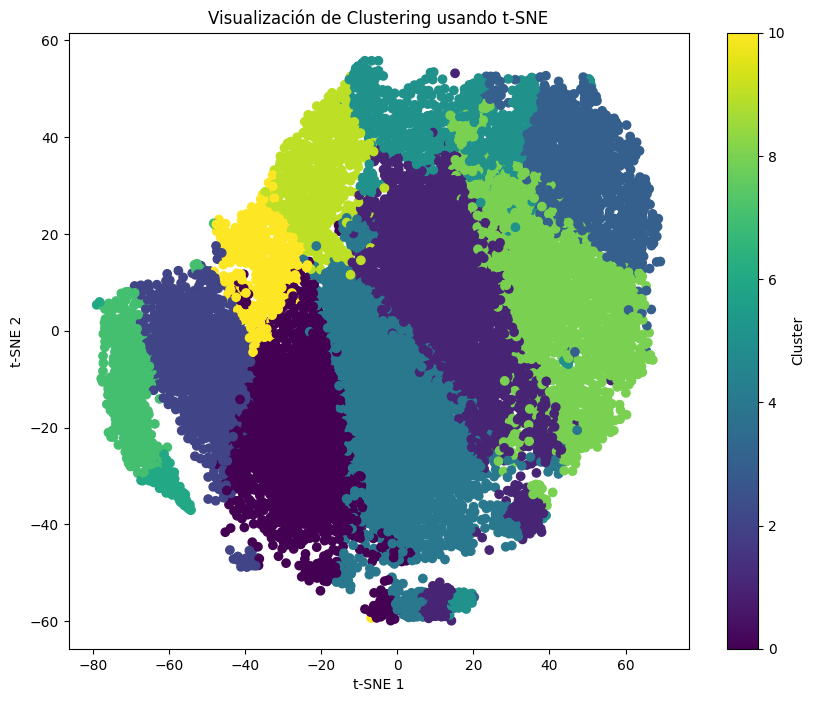

In [68]:
# Convertir los vectores Doc2Vec a cuDF DataFrame para usar en GPU
title_vectors = np.stack(df['doc2vec_vector'].values)

# Reducción de dimensionalidad usando t-SNE en GPU
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(title_vectors)

# Agregar las coordenadas t-SNE al DataFrame original
df['tsne_x'] = tsne_results[:, 0]
df['tsne_y'] = tsne_results[:, 1]

plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['tsne_x'], df['tsne_y'], c=df['cluster'], cmap='viridis')
plt.colorbar(scatter, label='Cluster')
plt.title('Visualización de Clustering usando t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

Cuando los títulos pertenecen al mismo cluster, podemos ajustar el score de similitud, dándole mayor peso a las comparaciones dentro del mismo grupo. Esto es útil porque dentro de un cluster se espera que los títulos sean más similares, y ajustar el score refuerza esta idea.

In [14]:
# Ajustar el score basado en la pertenencia al cluster

def ajustar_score(ensemble_score, df):
    # Convertir ensemble_score a cupy
    ensemble_score_cp = cp.array(ensemble_score)

    # Convertir clusters a cupy
    cluster_cp = cp.array(df['cluster'].values)

    # Crear matrices de índice para realizar comparaciones
    n = len(df)
    idx_i, idx_j = cp.meshgrid(cp.arange(n), cp.arange(n), indexing='ij')

    # Filtrar donde idx_i != idx_j para evitar comparaciones consigo mismo
    mask = idx_i < idx_j  # Solo necesitamos una mitad del triángulo superior

    # Extraer los valores relevantes
    idx_i = idx_i[mask]
    idx_j = idx_j[mask]

    # Obtener scores y clusters para los pares de títulos
    scores = ensemble_score_cp[idx_i, idx_j]
    cluster_i = cluster_cp[idx_i]
    cluster_j = cluster_cp[idx_j]

    # Ajustar los scores basado en la pertenencia al cluster
    adjustment = cp.where(cluster_i == cluster_j, 1.1, 0.9)
    adjusted_scores = scores * adjustment

    # Convertir los resultados a numpy para almacenar en pandas DataFrame
    idx_i = cp.asnumpy(idx_i)
    idx_j = cp.asnumpy(idx_j)
    adjusted_scores = cp.asnumpy(adjusted_scores)
    cluster_i = cp.asnumpy(cluster_i)
    cluster_j = cp.asnumpy(cluster_j)

    # Crear un DataFrame con los resultados
    results = pd.DataFrame({
        'ITE_ITEM_TITLE_1': df['ITE_ITEM_TITLE'].iloc[idx_i].values,
        'ITE_ITEM_TITLE_2': df['ITE_ITEM_TITLE'].iloc[idx_j].values,
        'Score_Similitud': adjusted_scores,
        'Cluster_1': cluster_i,
        'Cluster_2': cluster_j
    })

    return results

In [71]:
results = ajustar_score(ensemble_score, df)

In [72]:
results

,ITE_ITEM_TITLE_1,ITE_ITEM_TITLE_2,Score_Similitud,Cluster_1,Cluster_2
0,tãnis olympikus esporte valente masculino kids,bicicleta barra forte samy c marchas cubo c ro...,0.428106,3,7
1,tãnis olympikus esporte valente masculino kids,tãnis usthemp slipon temãâtico labrador,0.472164,3,1
2,tãnis olympikus esporte valente masculino kids,tãnis casual feminino moleca tecido tie dye,0.539816,3,8
3,tãnis olympikus esporte valente masculino kids,tãnis star baby sapatinho conforto brinde,0.515334,3,8
4,tãnis olympikus esporte valente masculino kids,tãnis oakley frequency pretomarrom,0.430770,3,2
...,...,...,...,...,...
49994995,sapatenis casual masculino estiloso horas conf...,tãnis feminino leve barato ganhe colchonete p ...,0.795969,4,0
49994996,sapatenis casual masculino estiloso horas conf...,tãnis polo ralph lauren modelo cantor low bran...,0.793188,4,2
49994997,tãnis feminino infantil molekinha tie dye,tãnis feminino leve barato ganhe colchonete p ...,0.757611,1,0
49994998,tãnis feminino infantil molekinha tie dye,tãnis polo ralph lauren modelo cantor low bran...,0.761382,1,2


# **Evaluación de la Escalabilidad**

In [17]:
df_Total = pd.read_csv('/home/insightlab/Documents/MercadoLibre/arquivos/items_titles_test.csv', encoding='latin1')

In [18]:
def clean_resources():
    # Limpieza de GPU
    torch.cuda.empty_cache()
    cp.get_default_memory_pool().free_all_blocks()
    
    # Limpieza de RAM y CPU
    gc.collect()

In [19]:
sizes = []
times = []
cpu_usages = []
gpu_usages = []
# DataFrame vacío para almacenar los resultados
final_results_df = pd.DataFrame()

In [20]:
for size in [1000, 3000, 5000, 8000, 10000]:  # Valores con lo que trabajaremos en nuestro dataset
    df = df_Total.head(size)

    clean_resources()  # Limpiar recursos antes de cada prueba
    
    # Medir uso de CPU y GPU antes
    cpu_before = psutil.cpu_percent(interval=1)
    gpu_before = GPUtil.getGPUs()[0].load * 100
    start_time = time.time()  # Iniciar medición de tiempo

    # Procesar datos
    num_unique_titles = df['ITE_ITEM_TITLE'].nunique()
    df['ITE_ITEM_TITLE'] = df['ITE_ITEM_TITLE'].str.lower()
    df = df.dropna(subset=['ITE_ITEM_TITLE'])
    df['ITE_ITEM_TITLE'] = df['ITE_ITEM_TITLE'].apply(clean_text)
    portuguese_stopwords = set(stopwords.words('portuguese'))
    df['ITE_ITEM_TITLE'] = df['ITE_ITEM_TITLE'].apply(remove_stopwords_pt)
    df['ID'] = range(len(df))
    
    # eliminacion_de_ruido
    df['tokens'] = df['ITE_ITEM_TITLE'].apply(clean_and_tokenize)

    # N-Gramas y TF-IDF
    df_cudf = cudf.DataFrame.from_pandas(df)
    tfidf_vectorizer = cuTfidfVectorizer(ngram_range=(1, 3), min_df=2)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df_cudf['ITE_ITEM_TITLE'])

    # captura_semantica
    word2vec_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4)
    word2vec_model.save("word2vec.model")
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['tokens'])]
    doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=1, workers=4)
    doc2vec_model.save("doc2vec.model")
    df['word2vec_vector'] = df['tokens'].apply(lambda x: get_title_vector(x, word2vec_model))
    df['doc2vec_vector'] = [doc2vec_model.dv[i] for i in range(len(df))]

    # calculo_coseno
    cosine_sim_tfidf = pairwise_distances(tfidf_matrix.toarray(), metric='cosine', device=device)
    cosine_sim_word2vec = cosine_similarity(np.stack(df['word2vec_vector'].values))
    cosine_sim_doc2vec = cosine_similarity(np.stack(df['doc2vec_vector'].values))
    wmd_sim = np.array([[wmd_similarity(word2vec_model, doc1, doc2) for doc2 in df['tokens']] for doc1 in df['tokens']])
    wmd_sim = 1 / (1 + wmd_sim)
    wmd_sim = (wmd_sim - np.min(wmd_sim)) / (np.max(wmd_sim) - np.min(wmd_sim))
    cosine_sim_tfidf = cp.array(cosine_sim_tfidf)
    cosine_sim_word2vec = cp.array(cosine_sim_word2vec)
    cosine_sim_doc2vec = cp.array(cosine_sim_doc2vec)
    wmd_sim = cp.array(wmd_sim)
    ensemble_score = (cosine_sim_tfidf + cosine_sim_word2vec + cosine_sim_doc2vec + wmd_sim) / 4

    # Cálculo de la similitud utilizando embeddings
    title_vectors_cudf = cudf.DataFrame.from_records(np.stack(df['doc2vec_vector'].values))
    title_vectors = np.stack(df['doc2vec_vector'].values)

    # Cálculo de clustering
    c_max = math.floor(num_unique_titles / 10)
    n_clusters_range = (10, c_max )
    best_n_clusters, best_labels, best_db_index = optimize_n_clusters(title_vectors_cudf, title_vectors, n_clusters_range)
    df['cluster'] = best_labels
    
    # Ajustar el score basado en la pertenencia al cluster
    results = ajustar_score(ensemble_score, df)

    # Añadir la columna 'size' a los resultados
    results['size'] = size

    # Concatenar los resultados al DataFrame final
    final_results_df = pd.concat([final_results_df, results], ignore_index=True)
    
    end_time = time.time()  # Terminar medición de tiempo
    
    # Medir uso de CPU y GPU después
    cpu_after = psutil.cpu_percent(interval=1)
    gpu_after = GPUtil.getGPUs()[0].load * 100
    # Calcular tiempo de ejecución
    execution_time = end_time - start_time
    
    # Almacenar el tamaño y el tiempo
    sizes.append(size)
    times.append(execution_time)
    cpu_usages.append(cpu_after)
    gpu_usages.append(gpu_after)

    # Guardar el DataFrame en un archivo CSV
    df_results = pd.DataFrame({
        'Tamaño del Dataset': sizes,
        'Tiempo de Ejecución (segundos)': times,
        'Uso de CPU (%)': cpu_usages,
        'Uso de GPU (%)': gpu_usages
    })
    df_results.to_csv('resultados_escalabilidad.csv', index=False)
    final_results_df.to_csv('resultados_con_tamanos.csv', index=False)
    
    print(f"Tamaño del dataset: {size}, Tiempo de ejecución: {execution_time:.2f} segundos, Uso de CPU: {cpu_after:.2f}%, Uso de GPU: {gpu_after:.2f}%")

/tmp/ipykernel_35593/1103325507.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ITE_ITEM_TITLE'] = df['ITE_ITEM_TITLE'].str.lower()
2024-09-04 15:22:50.783345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 15:22:50.797301: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 15:22:50.797326: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has alr

Tamaño del dataset: 1000, Tiempo de ejecución: 257.32 segundos, Uso de CPU: 4.50%, Uso de GPU: 7.00%


/tmp/ipykernel_35593/1103325507.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ITE_ITEM_TITLE'] = df['ITE_ITEM_TITLE'].str.lower()


Tamaño del dataset: 3000, Tiempo de ejecución: 2434.95 segundos, Uso de CPU: 2.00%, Uso de GPU: 7.00%


/tmp/ipykernel_35593/1103325507.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ITE_ITEM_TITLE'] = df['ITE_ITEM_TITLE'].str.lower()


Tamaño del dataset: 5000, Tiempo de ejecución: 6753.56 segundos, Uso de CPU: 2.30%, Uso de GPU: 6.00%


/tmp/ipykernel_35593/1103325507.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ITE_ITEM_TITLE'] = df['ITE_ITEM_TITLE'].str.lower()


Tamaño del dataset: 8000, Tiempo de ejecución: 17548.05 segundos, Uso de CPU: 1.10%, Uso de GPU: 0.00%
Tamaño del dataset: 10000, Tiempo de ejecución: 27992.38 segundos, Uso de CPU: 1.10%, Uso de GPU: 0.00%


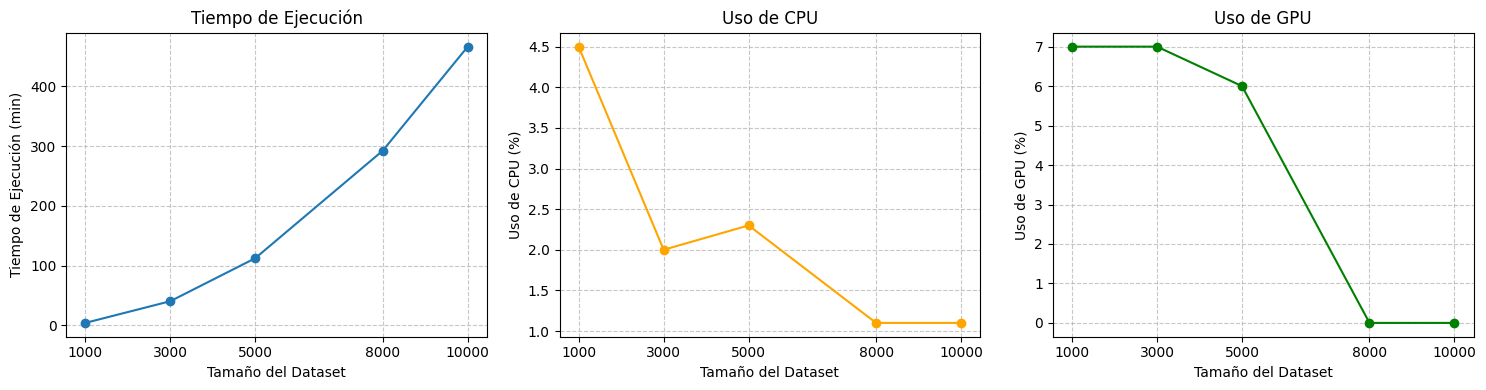

In [25]:
times_in_minutes = [t / 60 for t in times]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(sizes, times_in_minutes, marker='o', label='Tiempo de Ejecución', linestyle='-')
axes[0].set_xticks(sizes)
axes[0].set_xlabel('Tamaño del Dataset')
axes[0].set_ylabel('Tiempo de Ejecución (min)')
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].set_title('Tiempo de Ejecución')

axes[1].plot(sizes, cpu_usages, marker='o', label='Uso de CPU', linestyle='-', color='orange')
axes[1].set_xticks(sizes)
axes[1].set_xlabel('Tamaño del Dataset')
axes[1].set_ylabel('Uso de CPU (%)')
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_title('Uso de CPU')

axes[2].plot(sizes, gpu_usages, marker='o', label='Uso de GPU', linestyle='-', color='green')
axes[2].set_xticks(sizes)
axes[2].set_xlabel('Tamaño del Dataset')
axes[2].set_ylabel('Uso de GPU (%)')
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].set_title('Uso de GPU')
plt.tight_layout()
plt.show()

El gráfico del tiempo de ejecución nos muestra un aumento significativo a medida que el tamaño del dataset crece, observamos la tendencia exponencial en el tiempo de ejecución cuando el tamaño del dataset pasa de 1000 a 10,000, el tiempo de ejecución aumenta de manera muy pronunciada alcanzando más de 400 minutos para el datasets de 10000, esto quiere decir que la tendencia no es lineal, lo cual es un indicativo de que la solución no escala bien para datasets más grandes. Sin embargo este tiempo demorado está en relación a cálculo WMD que se aplica a todas las combinaciones posibles que se tiene en el datasets, quizas para poder optimizar el tiempo seria implementar el clustering antes del calculo WMD para que así solo se aplique entre los titulos que pertenecen al mismo clustering y no entre todas las combinaciones posibles, reduciendo comparaciones innecesarias, realizar el cálculo del clustering primero y luego calcular la similitud entre los títulos dentro de los clusters sería más optimo en relación a recurso computacional.

En cuanto al uso de CPU y GPU, parece que no hay un aumento significativo en el uso de estos recursos a medida que el tamaño del dataset crece, esto podría significar que la carga de trabajo está más concentrada en operaciones de I/O (entrada/salida), memoria, cuello de botella (WMD), y no tanto en la carga computacional en CPU o GPU, lo que también afecta negativamente la escalabilidad.